In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [3]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170508288/170498071 [==============================] - 2s 0us/step


In [5]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [6]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [7]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

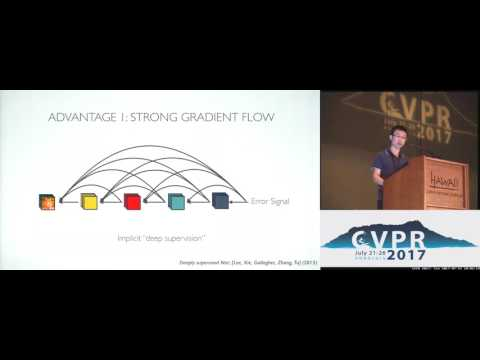

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [8]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
print(len(model.layers))

262


In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4404s 88ms/sample - loss: 1.7059 - accuracy: 0.3568 - val_loss: 1.6560 - val_accuracy: 0.4044
Epoch 2/10
50000/50000 [==============================] - 3571s 71ms/sample - loss: 1.3596 - accuracy: 0.4974 - val_loss: 1.3628 - val_accuracy: 0.5203
Epoch 3/10
 5632/50000 [==>...........................] - ETA: 46:21 - loss: 1.2483 - accuracy: 0.5424

KeyboardInterrupt: 

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 66s 7ms/sample - loss: 1.4938 - accuracy: 0.4969
Test loss: 1.493803402900696
Test accuracy: 0.4969


In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

### Assignment

In [22]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

In [23]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 25
l = 20
num_filter = 16
compression = 0.5
dropout_rate = 0

In [24]:
tf.config.run_functions_eagerly(True)

In [25]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [26]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_norm= X_train.astype('float32') 
test_norm= X_test.astype('float32')

X_train= train_norm/255.0 #rescaling between 0 and 1
X_test= test_norm/255.0
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [27]:

tf.keras.backend.clear_session()
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

In [28]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(shear_range=0.2,
                             zoom_range=0.2,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             horizontal_flip=True)

model = Model(inputs=[input], outputs=[output])
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model_1 = model.fit(datagen.flow(X_train, y_train, batch_size = 64),epochs = 100, 
                                 validation_data = (X_test, y_test), verbose=1,callbacks=[earlystopping,checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
782/782 [==============================] - 522s 622ms/step - loss: 1.6956 - accuracy: 0.3756 - val_loss: 1.5209 - val_accuracy: 0.4657

Epoch 00001: saving model to weights.hdf5
Epoch 2/100
782/782 [==============================] - 444s 568ms/step - loss: 1.3175 - accuracy: 0.5238 - val_loss: 1.3223 - val_accuracy: 0.5282

Epoch 00002: saving model to weights.hdf5
Epoch 3/100
782/782 [==============================] - 437s 559ms/step - loss: 1.1201 - accuracy: 0.5971 - val_loss: 1.2434 - val_accuracy: 0.5682

Epoch 00003: saving model to weights.hdf5
Epoch 4/100
782/782 [==============================] - 486s 622ms/step - loss: 1.0039 - accuracy: 0.6401 - val_loss: 1.3250 - val_accuracy: 0.5582

Epoch 00004: saving model to weights.hdf5
Epoch 5/100
782/782 [==============================] - 445s 569ms/step - loss: 0.9048 - accuracy: 0.6782 - val_loss: 1.5561 - val_accuracy: 0.5275

Epoch 00005: saving model to weights.hdf5
Epoch 6/100
782/782 [=============================

### Colab runtime disconnected on epoch 36 loading the saved model. and restaring the training from 36



In [30]:
model.load_weights("./weights.hdf5")
print("Weights Loaded")

Weights Loaded


In [31]:
filepath="weights_2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.03)

In [33]:
model_1 = model.fit(datagen.flow(X_train, y_train, batch_size = 64),epochs = 20, 
                                 validation_data = (X_test, y_test), verbose=1,callbacks=[earlystopping,checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
782/782 [==============================] - 495s 633ms/step - loss: 0.3298 - accuracy: 0.8834 - val_loss: 0.6518 - val_accuracy: 0.8048

Epoch 00001: saving model to weights_2.hdf5
Epoch 2/20
782/782 [==============================] - 452s 578ms/step - loss: 0.3273 - accuracy: 0.8842 - val_loss: 0.4485 - val_accuracy: 0.8560

Epoch 00002: saving model to weights_2.hdf5
Epoch 3/20
782/782 [==============================] - 446s 570ms/step - loss: 0.3189 - accuracy: 0.8890 - val_loss: 0.4523 - val_accuracy: 0.8488

Epoch 00003: saving model to weights_2.hdf5
Epoch 4/20
782/782 [==============================] - 453s 580ms/step - loss: 0.3075 - accuracy: 0.8922 - val_loss: 0.4626 - val_accuracy: 0.8504

Epoch 00004: saving model to weights_2.hdf5
Epoch 5/20
782/782 [==============================] - 455s 582ms/step - loss: 0.3074 - accuracy: 0.8927 - val_loss: 0.4823 - val_accuracy: 0.8426

Epoch 00005: saving model to weights_2.hdf5
Epoch 6/20
782/782 [=========================

### Accuracy is not improving beyond 0.84. So training was stopped with early stopping techinque in calback  on epoch 44 (32+12) and  loading the saved model, restaring the training with adaptive learning rate, ie. reducing the learning with each epoch

In [10]:
model.load_weights("weights_2.hdf5")
print("Weights Loaded")

Weights Loaded


In [ ]:
filepath="weights_3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2,verbose = 1)

In [ ]:
model_1 = model.fit(datagen.flow(X_train, y_train, batch_size = 128),epochs = 20, 
                                 validation_data = (X_test, y_test), verbose=1,callbacks=[earlystopping,checkpoint,lr_reduce])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
391/391 [==============================] - 414s 966ms/step - loss: 0.2342 - accuracy: 0.9182 - val_loss: 0.4517 - val_accuracy: 0.8605

Epoch 00001: saving model to weights_3.hdf5
Epoch 2/20
391/391 [==============================] - 378s 967ms/step - loss: 0.2239 - accuracy: 0.9210 - val_loss: 0.4564 - val_accuracy: 0.8623

Epoch 00002: saving model to weights_3.hdf5
Epoch 3/20
391/391 [==============================] - 336s 859ms/step - loss: 0.2197 - accuracy: 0.9224 - val_loss: 0.4992 - val_accuracy: 0.8511

Epoch 00003: saving model to weights_3.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/20
391/391 [==============================] - 332s 849ms/step - loss: 0.1801 - accuracy: 0.9368 - val_loss: 0.3609 - val_accuracy: 0.8864

Epoch 00004: saving model to weights_3.hdf5
Epoch 5/20
391/391 [==============================] - 336s 860ms/step - loss: 0.1717 - accuracy: 0.9405 - val_loss: 0.3720 - val_accuracy: 0.8846

Epoch 0

In [ ]:

from prettytable import PrettyTable 
table = PrettyTable()
table.field_names = ["Model", "Train AUC", "Test AUC"]
table.add_row(["Model", "0.93", "0.9"])
# table.add_row(["Model2", "0.816", "0.72"])
# table.add_row(["Model3", "0.893", "0.72"])
print(table)


+-------+-----------+----------+
| Model | Train AUC | Test AUC |
+-------+-----------+----------+
| Model |    0.93   |   0.9    |
+-------+-----------+----------+


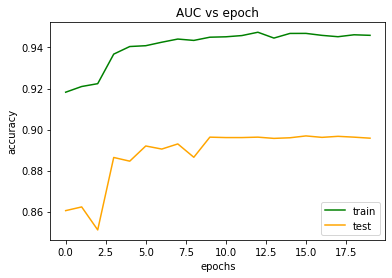

In [ ]:

import matplotlib.pyplot as plt
def accuracy_plot(history):
 plt.xlabel('epochs')
 plt.ylabel('accuracy')
 plt.title('AUC vs epoch')
 plt.plot(history.history['accuracy'], color='green', label='train')
 plt.plot(history.history['val_accuracy'], color='orange', label='test')
 plt.legend(loc ="lower right")
 plt.show()
accuracy_plot(model_1)

CIFAR 10 assignmnet was done with following restrictions:
1. No.of trainable parameters < 1 Million
2. No droput layers were included
3. No. of epoch was less than 300

Multiple experiments were carried out to come up with test accurcay of 90%. I had tried changing no. of filters, kernel initalization technique, optmizers etc.

Given dataset size was increased for training by using image augmentation techniques.
